# TRAIN 

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import shap
import xgboost as xgb 
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle

from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, RocCurveDisplay

/mnt/jack-5/amismailov/micromamba/envs/envs/amismailov/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
chromosome_means_10x_1 = pd.read_csv('/home/amismailov/chromosome_means_10x_1.csv', index_col=0)
chromosome_means_smartseq2 = pd.read_csv('/home/amismailov/chromosome_means_smartseq2.csv', index_col=0)

chromosome_means_normal_1 = pd.read_csv('/home/amismailov/chromosome_means_10x_1_stromal.csv', index_col=0)
chromosome_means_normal_3 = pd.read_csv('/home/amismailov/chromosome_means_smartseq2_stromal.csv', index_col=0)

In [4]:
# val set
chromosome_means_val_cancer = pd.read_csv('/home/amismailov/chromosome_means_smartseq_val_cancer.csv', index_col=0)
chromosome_means_val_stromal = pd.read_csv('/home/amismailov/chromosome_means_smartseq_val_stromal.csv', index_col=0)

In [9]:
df_gbm = pd.concat([chromosome_means_10x_1, chromosome_means_smartseq2, chromosome_means_val_cancer])
df_normal = pd.concat([chromosome_means_normal_1, chromosome_means_normal_3, chromosome_means_val_stromal])

In [10]:
df_gbm = df_gbm.reset_index(drop=True)
df_normal = df_normal.reset_index(drop=True)

In [11]:
df_gbm['label'] = [1 for _ in range(len(df_gbm))]
df_normal['label'] = [0 for _ in range(len(df_normal))]

In [12]:
df_normal.shape

(4543, 23)

In [13]:
df_gbm.shape

(7889, 23)

In [14]:
df = pd.concat([df_gbm, df_normal])

In [15]:
df

,Chr1,Chr2,Chr3,Chr4,Chr5,Chr6,Chr7,Chr8,Chr9,Chr10,...,Chr14,Chr15,Chr16,Chr17,Chr18,Chr19,Chr20,Chr21,Chr22,label
0,0.109700,0.148468,0.179212,0.136461,0.126194,0.128102,0.067593,0.163224,0.139124,0.223138,...,0.172620,0.155081,0.166391,0.264486,0.138187,0.150947,0.134983,0.092526,0.142757,1
1,0.149008,0.149658,0.140772,0.114675,0.145186,0.148834,0.150935,0.147325,0.225406,0.149823,...,0.136706,0.170122,0.157906,0.184852,0.153877,0.137888,0.125479,0.143905,0.172244,1
2,0.105559,0.119560,0.079661,0.098095,0.112681,0.142018,0.064578,0.111722,0.100025,0.170170,...,0.114707,0.182003,0.113896,0.151203,0.118136,0.108088,0.128971,0.075441,0.166742,1
3,0.125178,0.110614,0.130932,0.147324,0.141995,0.142831,0.083367,0.125723,0.132879,0.164061,...,0.135845,0.211926,0.125472,0.191615,0.129496,0.119418,0.140216,0.179035,0.162174,1
4,0.155270,0.157135,0.159462,0.122125,0.141388,0.161522,0.097065,0.137579,0.174598,0.201187,...,0.150009,0.166951,0.170584,0.250287,0.154301,0.160376,0.142097,0.188320,0.156424,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4538,0.049873,0.046851,0.030868,0.045038,0.034348,0.047927,0.058034,0.042834,0.041211,0.027109,...,0.055324,0.052806,0.045900,0.046637,0.030438,0.051956,0.050060,0.067208,0.050097,0
4539,0.092820,0.072071,0.062650,0.067494,0.042963,0.074983,0.080310,0.051834,0.046796,0.065031,...,0.059071,0.080986,0.070514,0.052962,0.063919,0.072582,0.076841,0.063507,0.056030,0
4540,0.102280,0.110885,0.056415,0.060866,0.059422,0.073829,0.060635,0.072224,0.033338,0.069603,...,0.067897,0.067146,0.060037,0.068473,0.078912,0.072685,0.075375,0.048498,0.064803,0
4541,0.084284,0.123367,0.051752,0.047759,0.027217,0.092900,0.062135,0.062068,0.049161,0.070030,...,0.048146,0.081347,0.074303,0.062280,0.064018,0.077901,0.073699,0.058717,0.072766,0


In [16]:
X = df.drop('label', axis=1)
y = df['label']

In [18]:
def plot_roc_auc(y_test_true, y_test_pred_probs, y_train_true=None, y_train_pred_probs=None):
    """
    Рисует ступенчатую ROC-AUC кривую для данных обучения и тестирования с заполненной областью под ней.

    Параметры:
     - y_train_true: Настоящие метки классов для данных обучения.
     - y_train_pred_probs: Предсказанные вероятности принадлежности к классу 1 для данных обучения.
     - y_test_true: Настоящие метки классов для данных тестирования.
     - y_test_pred_probs: Предсказанные вероятности принадлежности к классу 1 для данных тестирования.
    """
    if y_train_true is not None:
      fpr_train, tpr_train, _ = roc_curve(y_train_true, y_train_pred_probs)
      roc_auc_train = auc(fpr_train, tpr_train)

    fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_pred_probs)
    roc_auc_test = auc(fpr_test, tpr_test)

    plt.figure(figsize=(8, 6))

    if y_train_true is not None:
      plt.step(fpr_train, tpr_train, color='red', lw=1, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
      plt.fill_between(fpr_train, tpr_train, color='pink', alpha=0.75)

    plt.step(fpr_test, tpr_test, color='green', lw=1, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
    plt.fill_between(fpr_test, tpr_test, color='lightgreen', alpha=0.75)

    print("sds")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [19]:
def plot(chr='Chr1'):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    # Плотность распределения
    sns.kdeplot(data=chromosome_means[chr], fill = True, color='red', ax=axes[0])
    axes[0].set_title('Density distribution')
    
    # Гистограмма
    sns.histplot(data=chromosome_means[chr], bins=50, color='red', ax=axes[1])
    axes[1].set_title('Гистограмма')
    
    fig.suptitle(f'Статистика {chr}', fontsize=16)
    
    # Отображение графиков
    plt.tight_layout()
    plt.show()
    
def plot_dens(chr='Chr1', save_path=None):
    fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
    # Плотность распределения
    sns.kdeplot(data=chromosome_means[chr], fill = True, color='purple', ax=axes)
    #axes.set_title('Density distribution')
    fig.suptitle(f'Chromosome {chr[1:]} means', fontsize=20,fontweight='bold')
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

def plot_all(data, chr, save_path=None):
    fig, axes = plt.subplots(3, 7, figsize=(30, 15), dpi=100)
    
    plot_idx = 0
    for i in range(3):        # 4 строки
        for k in range(7):    # 5 столбцов (НЕ 4!)
            if plot_idx < len(chr):
                sns.kdeplot(data=data[chr[plot_idx]], 
                           fill=True, color='purple', ax=axes[i, k])
                axes[i, k].set_title(f'Chromosome {chr[plot_idx][1:]} means',fontweight='bold', fontsize=20)
                axes[i, k].set_xlabel('')
                axes[i, k].set_ylabel('')
                plot_idx += 1
            else:
                # Скрыть лишние subplot'ы если chr меньше 20
                axes[i, k].set_visible(False)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    plt.show()

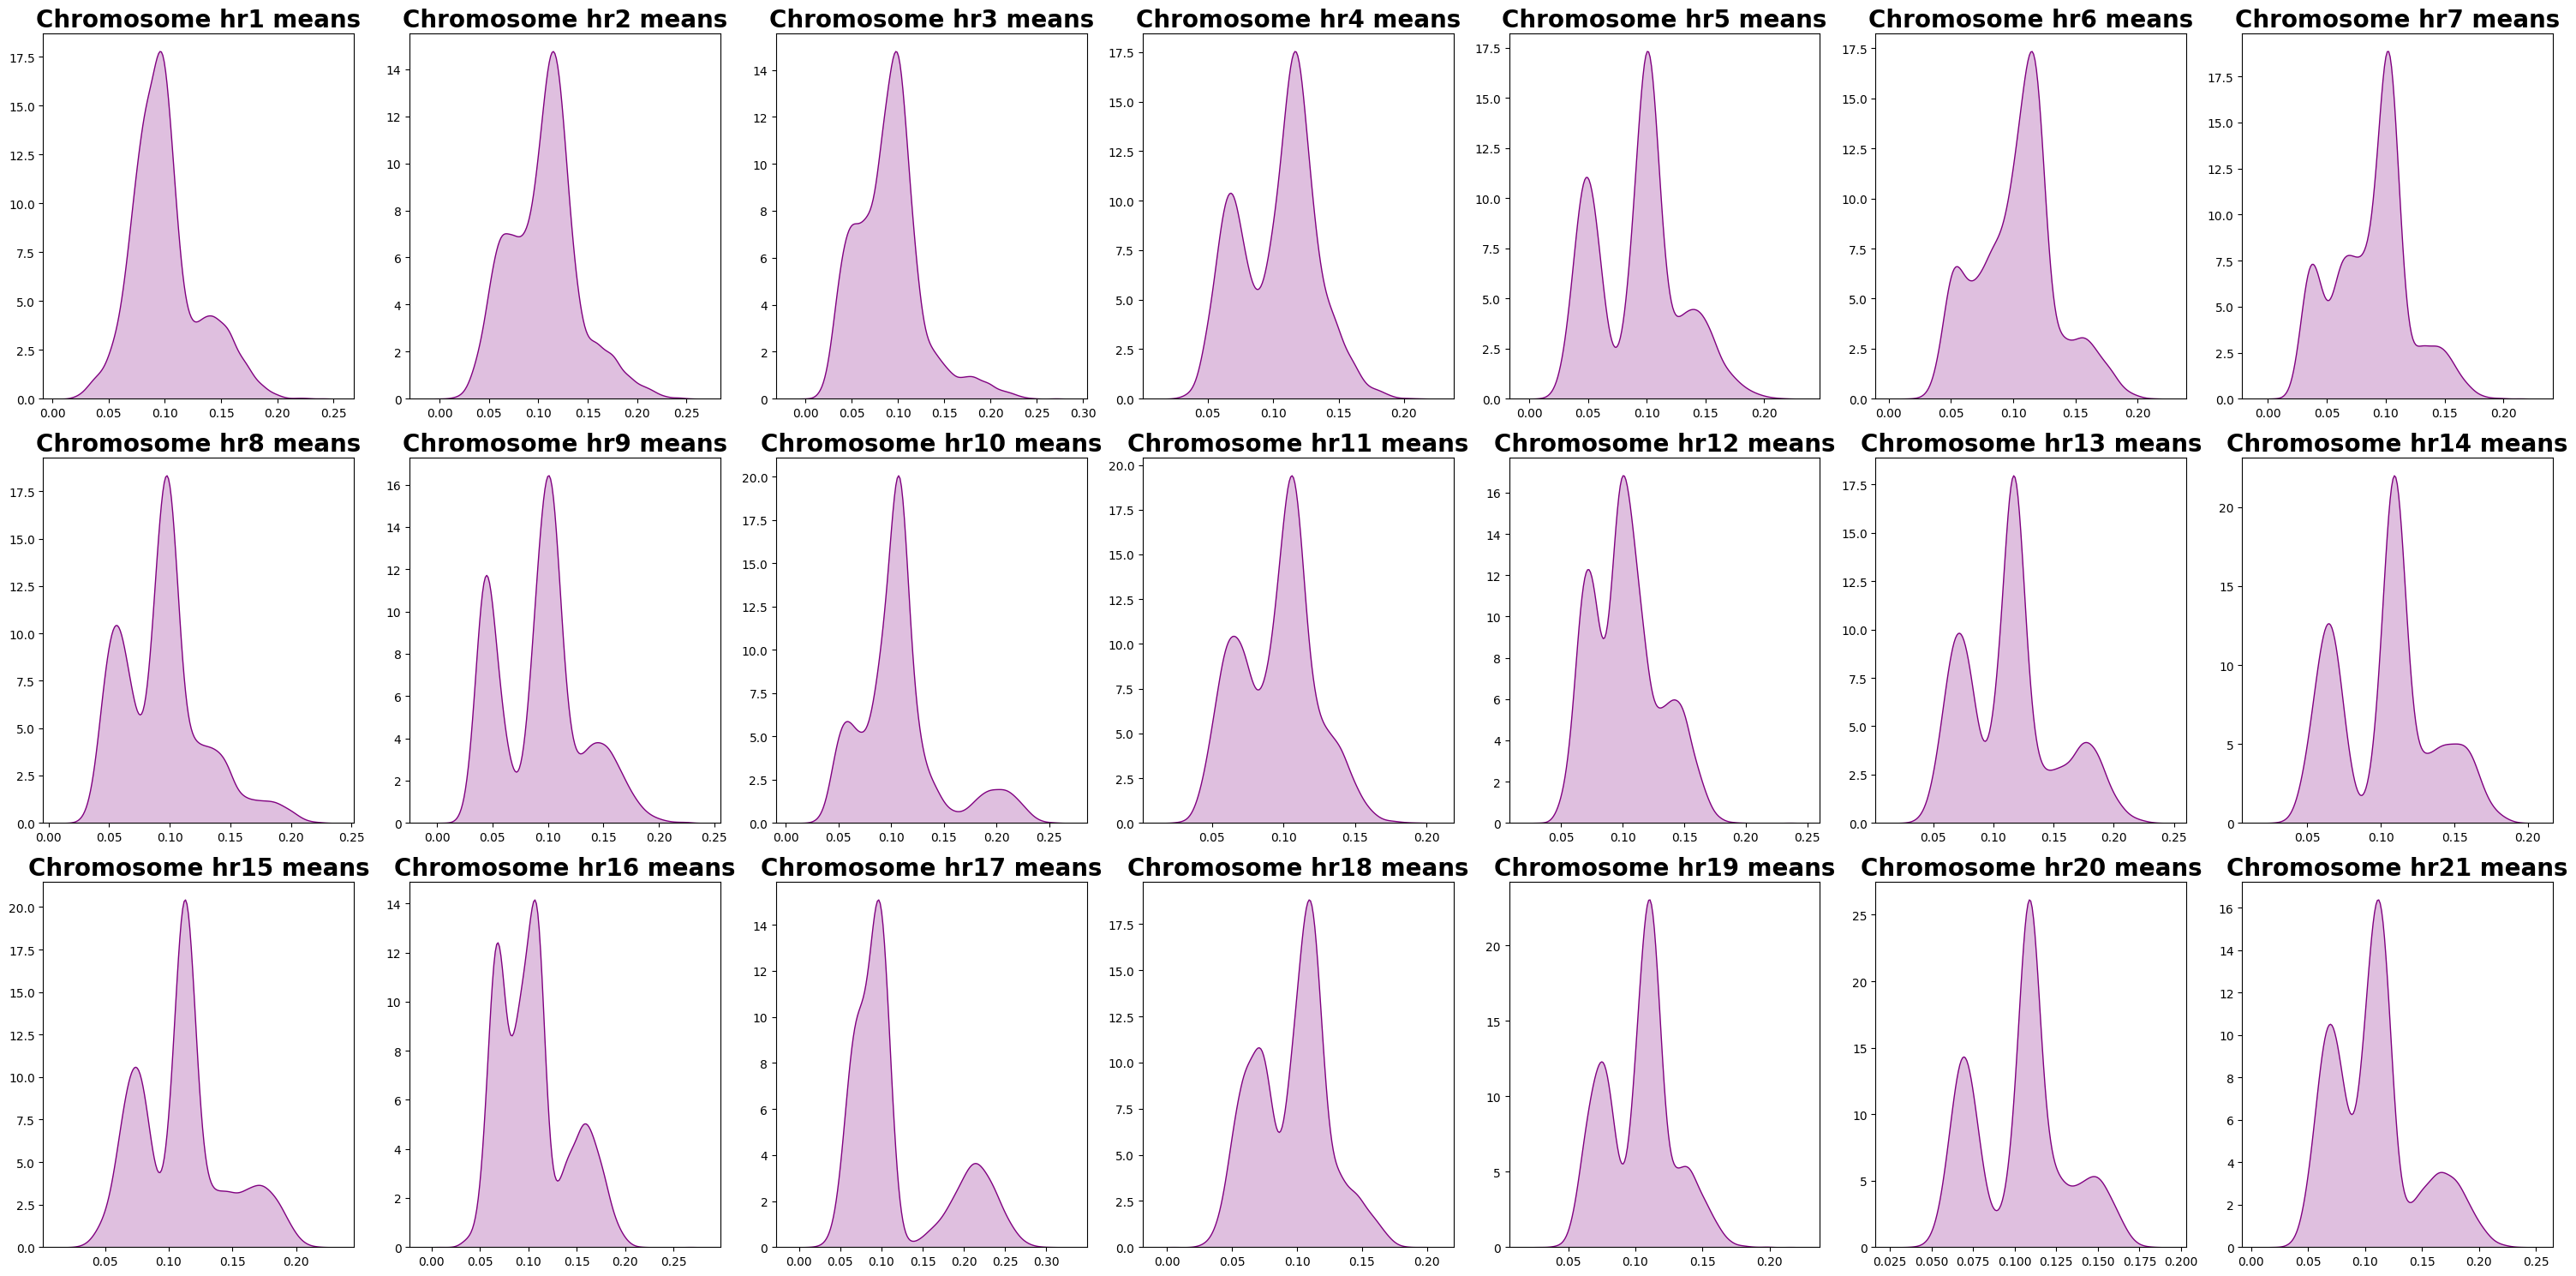

In [20]:
chr = [f'Chr{i+1}' for i in range(22)]
plot_all(X, chr)

In [21]:
corr = df.corr('spearman')
corr = -corr

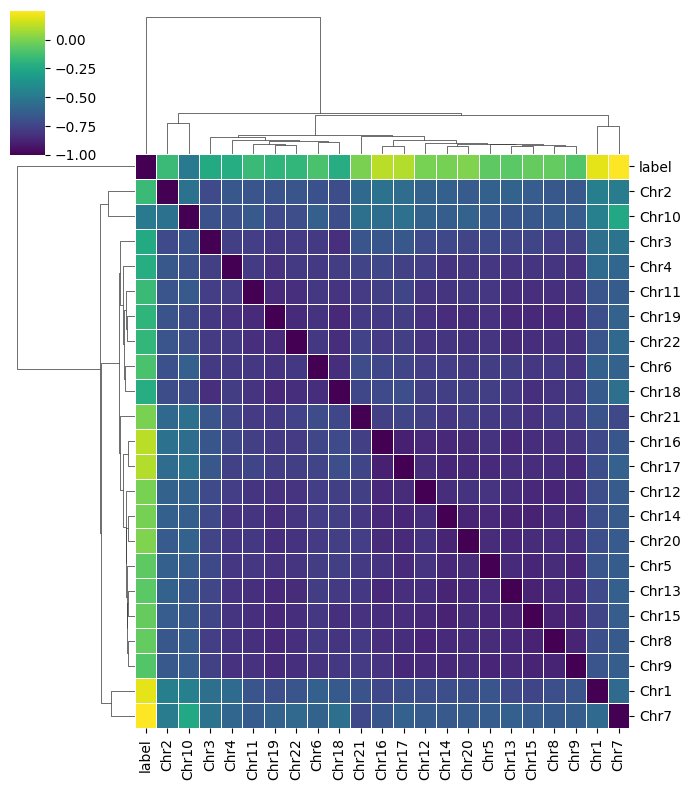

In [22]:
# Plot the data
cluster = sns.clustermap(corr,
                         cmap=sns.color_palette("viridis", as_cmap=True), linewidths=0.5,
                         linecolor='white', figsize=(7,8),
                         yticklabels=True,
                         xticklabels=True)

# Disable x axis labels
# hint: cluster.ax_heatmap is a simple matplotlib axis instance

# Add figure title
# hint: cluster.figure is a simple matplotlib figure
title = {
    'color' : 'black',
    'family' : 'serif',
    'weight' : 'bold',
    'size' : 12
}
#plt.text(7,2, "Spearman's correlation", fontdict=title)
plt.savefig('corr.jpg', dpi=300, bbox_inches='tight', facecolor='white')

In [23]:
X, y = shuffle(X, y, random_state=42)

In [17]:
#X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
model = xgb.XGBClassifier(
    # Booster parameters
    booster='gbtree',           
    tree_method='auto',         
    
    # Learning control
    learning_rate=0.1,          
    n_estimators=500,           
    
    # Tree-specific parameters
    max_depth=5,                
    min_child_weight=1,         
    gamma=0,                    
    
    # Regularization
    subsample=0.8,              
    colsample_bytree=0.8,       
    colsample_bylevel=0.8,     
    reg_alpha=1e-3,             # L1 
    reg_lambda=1,               # L2 
    
    # Scale positive weight for unbalanced data
    scale_pos_weight=1,         
    
    # Early stopping & verbosity
    verbosity=1,                
    random_state=42,            
    n_jobs=-1                   
)

model.fit(X, y)

,objective,'binary:logistic'
,base_score,None
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,0.8
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [65]:
model.save_model('GCF_config.json')

## VALIDATION

In [25]:
chromosome_means_val_main = pd.read_csv('/home/amismailov/chromosome_means_main_v2.csv', index_col=0)
chromosome_means_val_main

,Chr1,Chr2,Chr3,Chr4,Chr5,Chr6,Chr7,Chr8,Chr9,Chr10,...,Chr13,Chr14,Chr15,Chr16,Chr17,Chr18,Chr19,Chr20,Chr21,Chr22
sample1_CF1GTCGCTGGTGAA,0.069590,0.083677,0.036946,0.054123,0.040238,0.071070,0.063289,0.056239,0.039120,0.051658,...,0.066113,0.055272,0.061259,0.071651,0.080381,0.051743,0.060525,0.062224,0.057954,0.055179
sample1_CF1GGCTCGGGAGTC,0.066613,0.110298,0.048769,0.076006,0.028094,0.086776,0.056629,0.062449,0.068038,0.065915,...,0.092211,0.062403,0.072837,0.064307,0.072124,0.066760,0.070329,0.060826,0.062627,0.075275
sample1_CF3GTTTATGGGACC,0.098291,0.062389,0.032955,0.085140,0.052633,0.079611,0.080469,0.054093,0.044607,0.051129,...,0.072657,0.055208,0.074703,0.071027,0.082041,0.051851,0.074374,0.070244,0.063700,0.066809
sample1_CF1GACCCGAGCAGT,0.056608,0.113246,0.053957,0.092279,0.037802,0.064932,0.048213,0.066765,0.040557,0.077585,...,0.094396,0.064938,0.074574,0.070180,0.073410,0.076134,0.071020,0.068390,0.080881,0.076905
sample1_CF3GGACTGTATTAC,0.068413,0.091822,0.074473,0.092405,0.030549,0.064024,0.051552,0.066853,0.028146,0.078724,...,0.083904,0.061098,0.075662,0.068734,0.059842,0.077828,0.075977,0.072740,0.059032,0.086564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample7_ATACCGATATGC,0.038675,0.105252,0.076984,0.079189,0.052407,0.036094,0.022389,0.070374,0.044258,0.065758,...,0.080795,0.080827,0.063433,0.071683,0.080840,0.066373,0.081805,0.065276,0.052869,0.079453
sample7_ATAGATTACGTA,0.081249,0.098665,0.061905,0.068967,0.045031,0.084813,0.076848,0.073055,0.058420,0.053894,...,0.071943,0.064494,0.076472,0.058844,0.059094,0.070460,0.073229,0.059711,0.071967,0.085386
sample7_CTAGACTCGTGC,0.048838,0.097979,0.038988,0.046693,0.040923,0.044097,0.028683,0.042758,0.072297,0.061608,...,0.090456,0.063012,0.088923,0.074385,0.058132,0.076281,0.066641,0.062726,0.067051,0.078166
sample7_AAGCAACAACTG,0.066594,0.095204,0.026606,0.048885,0.042906,0.070257,0.045143,0.036860,0.047988,0.041187,...,0.049999,0.055940,0.064281,0.045034,0.071352,0.032001,0.054925,0.057766,0.055504,0.050239


In [26]:
cancer_barcodes_valid = pd.read_csv('/home/amismailov/cancer_barcodes_validation.csv')['cell'].tolist()
stromal_barcodes_valid = pd.read_csv('/home/amismailov/stromal_barcodes_validation.csv')['cell'].tolist()

In [27]:
df_cancer_valid = chromosome_means_val_main[chromosome_means_val_main.index.isin(cancer_barcodes_valid)]
df_stromal_valid = chromosome_means_val_main[chromosome_means_val_main.index.isin(stromal_barcodes_valid)]

In [28]:
df_cancer_valid = df_cancer_valid.copy()
df_stromal_valid = df_stromal_valid.copy()

df_cancer_valid.loc[:, 'label'] = 1
df_stromal_valid.loc[:, 'label'] = 0

In [29]:
df_valid = pd.concat([df_cancer_valid, df_stromal_valid])
df_valid

,Chr1,Chr2,Chr3,Chr4,Chr5,Chr6,Chr7,Chr8,Chr9,Chr10,...,Chr14,Chr15,Chr16,Chr17,Chr18,Chr19,Chr20,Chr21,Chr22,label
sample1_CF1GGCTCGGGAGTC,0.066613,0.110298,0.048769,0.076006,0.028094,0.086776,0.056629,0.062449,0.068038,0.065915,...,0.062403,0.072837,0.064307,0.072124,0.066760,0.070329,0.060826,0.062627,0.075275,1
sample1_CF1GACCCGAGCAGT,0.056608,0.113246,0.053957,0.092279,0.037802,0.064932,0.048213,0.066765,0.040557,0.077585,...,0.064938,0.074574,0.070180,0.073410,0.076134,0.071020,0.068390,0.080881,0.076905,1
sample1_CF3GGACTGTATTAC,0.068413,0.091822,0.074473,0.092405,0.030549,0.064024,0.051552,0.066853,0.028146,0.078724,...,0.061098,0.075662,0.068734,0.059842,0.077828,0.075977,0.072740,0.059032,0.086564,1
sample1_CF1ATACACATCGTA,0.050393,0.097027,0.049017,0.092231,0.032332,0.070004,0.040872,0.065660,0.041075,0.081612,...,0.060373,0.073481,0.068256,0.070081,0.065261,0.064903,0.066149,0.067009,0.069543,1
sample1_CF1ACAACTGACAGA,0.047011,0.093198,0.054606,0.094646,0.031283,0.058095,0.039476,0.064211,0.043813,0.078500,...,0.060355,0.081066,0.061154,0.076276,0.064502,0.068328,0.064050,0.059735,0.080891,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample7_GTTTTGTACTGA,0.058559,0.095637,0.030599,0.066744,0.069669,0.059442,0.062683,0.032318,0.040660,0.042503,...,0.047865,0.051106,0.049741,0.056870,0.052366,0.048552,0.058975,0.074741,0.051105,0
sample7_GTGGGGTTTGAA,0.069729,0.054664,0.023287,0.058257,0.038850,0.044105,0.059820,0.032103,0.021924,0.034622,...,0.084080,0.056645,0.059884,0.045912,0.033920,0.047123,0.052781,0.049585,0.052942,0
sample7_CACTGCGAGCCT,0.095188,0.093859,0.054487,0.062323,0.041767,0.083277,0.046732,0.060411,0.065071,0.066460,...,0.066627,0.079949,0.055649,0.065826,0.056837,0.076162,0.071780,0.057188,0.076167,0
sample7_ACACGGCGTTCT,0.059421,0.031955,0.015185,0.058753,0.034999,0.060814,0.041454,0.034964,0.022595,0.043130,...,0.079215,0.056180,0.053966,0.059076,0.051542,0.050774,0.057497,0.061606,0.053483,0


In [30]:
X_valid = df_valid.drop('label', axis=1)
y_valid = df_valid['label']

X_valid, y_valid = shuffle(X, y, random_state=42)

In [60]:
y_pred_val = model.predict_proba(X_valid)[:, 1]

In [61]:
print("Test ROC AUC:", round(roc_auc_score(y_valid, y_pred_val), 3))
print(classification_report(y_valid, (y_pred_val >= 0.5).astype(int)))

Test ROC AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4543
           1       1.00      1.00      1.00      7889

    accuracy                           1.00     12432
   macro avg       1.00      1.00      1.00     12432
weighted avg       1.00      1.00      1.00     12432



sds


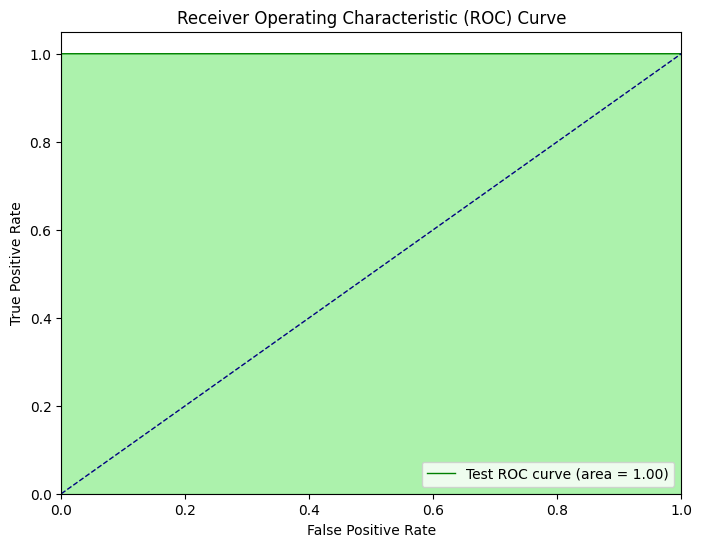

In [33]:
plot_roc_auc(y_valid, y_pred_val)

In [62]:
# SHAP-значения на валидации
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_valid)  # ndarray (n_samples, n_features)

# Глобальная важность: mean(|SHAP|) по каждому признаку
mean_abs_shap = np.abs(shap_values).mean(axis=0)
fi = pd.Series(mean_abs_shap, index=X_valid.columns).sort_values(ascending=False)

print("Top-10 SHAP importances:")
print(fi.head(10))

Top-10 SHAP importances:
Chr10    3.462010
Chr7     1.585416
Chr16    1.528077
Chr17    1.177079
Chr4     0.891837
Chr1     0.784896
Chr19    0.734070
Chr20    0.656456
Chr21    0.586821
Chr22    0.552361
dtype: float32


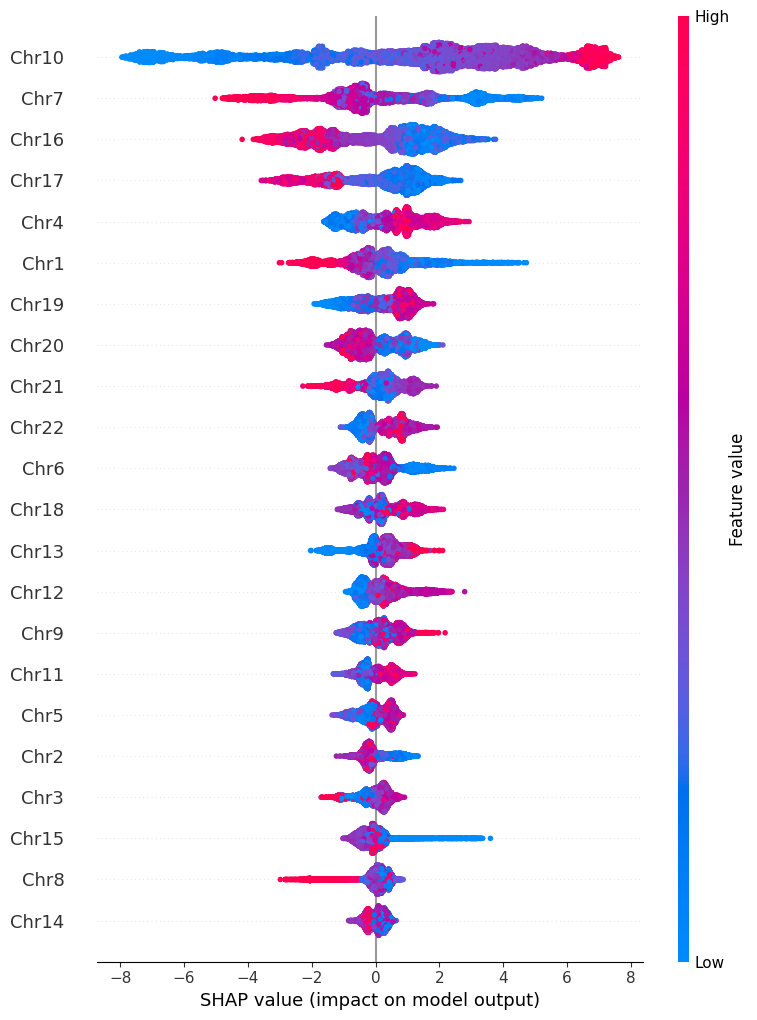

In [63]:
shap.summary_plot(shap_values, X_valid, max_display=22, show=False)

In [64]:
shap.summary_plot(shap_values, X_valid, max_display=22, show=False)
plt.tight_layout()
plt.savefig("shap_summary.svg", dpi=300, bbox_inches="tight")
plt.close()

## VALIDATION results for annotation

In [66]:
chromosome_means_val_main

,Chr1,Chr2,Chr3,Chr4,Chr5,Chr6,Chr7,Chr8,Chr9,Chr10,...,Chr16,Chr17,Chr18,Chr19,Chr20,Chr21,Chr22,proba,pred,label
sample1_CF1GTCGCTGGTGAA,0.069590,0.083677,0.036946,0.054123,0.040238,0.071070,0.063289,0.056239,0.039120,0.051658,...,0.071651,0.080381,0.051743,0.060525,0.062224,0.057954,0.055179,0.000396,0,sample1_CF1GTCGCTGGTGAA
sample1_CF1GGCTCGGGAGTC,0.066613,0.110298,0.048769,0.076006,0.028094,0.086776,0.056629,0.062449,0.068038,0.065915,...,0.064307,0.072124,0.066760,0.070329,0.060826,0.062627,0.075275,0.915484,1,sample1_CF1GGCTCGGGAGTC
sample1_CF3GTTTATGGGACC,0.098291,0.062389,0.032955,0.085140,0.052633,0.079611,0.080469,0.054093,0.044607,0.051129,...,0.071027,0.082041,0.051851,0.074374,0.070244,0.063700,0.066809,0.000164,0,sample1_CF3GTTTATGGGACC
sample1_CF1GACCCGAGCAGT,0.056608,0.113246,0.053957,0.092279,0.037802,0.064932,0.048213,0.066765,0.040557,0.077585,...,0.070180,0.073410,0.076134,0.071020,0.068390,0.080881,0.076905,0.999833,1,sample1_CF1GACCCGAGCAGT
sample1_CF3GGACTGTATTAC,0.068413,0.091822,0.074473,0.092405,0.030549,0.064024,0.051552,0.066853,0.028146,0.078724,...,0.068734,0.059842,0.077828,0.075977,0.072740,0.059032,0.086564,0.999658,1,sample1_CF3GGACTGTATTAC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample7_ATACCGATATGC,0.038675,0.105252,0.076984,0.079189,0.052407,0.036094,0.022389,0.070374,0.044258,0.065758,...,0.071683,0.080840,0.066373,0.081805,0.065276,0.052869,0.079453,0.985594,1,sample7_ATACCGATATGC
sample7_ATAGATTACGTA,0.081249,0.098665,0.061905,0.068967,0.045031,0.084813,0.076848,0.073055,0.058420,0.053894,...,0.058844,0.059094,0.070460,0.073229,0.059711,0.071967,0.085386,0.000076,0,sample7_ATAGATTACGTA
sample7_CTAGACTCGTGC,0.048838,0.097979,0.038988,0.046693,0.040923,0.044097,0.028683,0.042758,0.072297,0.061608,...,0.074385,0.058132,0.076281,0.066641,0.062726,0.067051,0.078166,0.855976,1,sample7_CTAGACTCGTGC
sample7_AAGCAACAACTG,0.066594,0.095204,0.026606,0.048885,0.042906,0.070257,0.045143,0.036860,0.047988,0.041187,...,0.045034,0.071352,0.032001,0.054925,0.057766,0.055504,0.050239,0.002738,0,sample7_AAGCAACAACTG


In [37]:
chromosome_means_val_main["proba"] = model.predict_proba(chromosome_means_val_main)[:, 1]
chromosome_means_val_main["pred"] = (chromosome_means_val_main["proba"] >= 0.5).astype(int)

chromosome_means_val_main

,Chr1,Chr2,Chr3,Chr4,Chr5,Chr6,Chr7,Chr8,Chr9,Chr10,...,Chr15,Chr16,Chr17,Chr18,Chr19,Chr20,Chr21,Chr22,proba,pred
sample1_CF1GTCGCTGGTGAA,0.069590,0.083677,0.036946,0.054123,0.040238,0.071070,0.063289,0.056239,0.039120,0.051658,...,0.061259,0.071651,0.080381,0.051743,0.060525,0.062224,0.057954,0.055179,0.000396,0
sample1_CF1GGCTCGGGAGTC,0.066613,0.110298,0.048769,0.076006,0.028094,0.086776,0.056629,0.062449,0.068038,0.065915,...,0.072837,0.064307,0.072124,0.066760,0.070329,0.060826,0.062627,0.075275,0.915484,1
sample1_CF3GTTTATGGGACC,0.098291,0.062389,0.032955,0.085140,0.052633,0.079611,0.080469,0.054093,0.044607,0.051129,...,0.074703,0.071027,0.082041,0.051851,0.074374,0.070244,0.063700,0.066809,0.000164,0
sample1_CF1GACCCGAGCAGT,0.056608,0.113246,0.053957,0.092279,0.037802,0.064932,0.048213,0.066765,0.040557,0.077585,...,0.074574,0.070180,0.073410,0.076134,0.071020,0.068390,0.080881,0.076905,0.999833,1
sample1_CF3GGACTGTATTAC,0.068413,0.091822,0.074473,0.092405,0.030549,0.064024,0.051552,0.066853,0.028146,0.078724,...,0.075662,0.068734,0.059842,0.077828,0.075977,0.072740,0.059032,0.086564,0.999658,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample7_ATACCGATATGC,0.038675,0.105252,0.076984,0.079189,0.052407,0.036094,0.022389,0.070374,0.044258,0.065758,...,0.063433,0.071683,0.080840,0.066373,0.081805,0.065276,0.052869,0.079453,0.985594,1
sample7_ATAGATTACGTA,0.081249,0.098665,0.061905,0.068967,0.045031,0.084813,0.076848,0.073055,0.058420,0.053894,...,0.076472,0.058844,0.059094,0.070460,0.073229,0.059711,0.071967,0.085386,0.000076,0
sample7_CTAGACTCGTGC,0.048838,0.097979,0.038988,0.046693,0.040923,0.044097,0.028683,0.042758,0.072297,0.061608,...,0.088923,0.074385,0.058132,0.076281,0.066641,0.062726,0.067051,0.078166,0.855976,1
sample7_AAGCAACAACTG,0.066594,0.095204,0.026606,0.048885,0.042906,0.070257,0.045143,0.036860,0.047988,0.041187,...,0.064281,0.045034,0.071352,0.032001,0.054925,0.057766,0.055504,0.050239,0.002738,0


In [38]:
chromosome_means_val_main['pred'].value_counts()

pred
1    11615
0    10650
Name: count, dtype: int64

In [39]:
chromosome_means_val_main['label'] = chromosome_means_val_main.index
res = chromosome_means_val_main[['label', 'proba', 'pred']]
res = res.reset_index(drop=True)
res 

,label,proba,pred
0,sample1_CF1GTCGCTGGTGAA,0.000396,0
1,sample1_CF1GGCTCGGGAGTC,0.915484,1
2,sample1_CF3GTTTATGGGACC,0.000164,0
3,sample1_CF1GACCCGAGCAGT,0.999833,1
4,sample1_CF3GGACTGTATTAC,0.999658,1
...,...,...,...
22260,sample7_ATACCGATATGC,0.985594,1
22261,sample7_ATAGATTACGTA,0.000076,0
22262,sample7_CTAGACTCGTGC,0.855976,1
22263,sample7_AAGCAACAACTG,0.002738,0


In [40]:
label = ['Glioblastoma cells' if x == 1 else 'Stromal cells' for x in res['pred'].tolist()]

In [41]:
res['class'] = label
res

,label,proba,pred,class
0,sample1_CF1GTCGCTGGTGAA,0.000396,0,Stromal cells
1,sample1_CF1GGCTCGGGAGTC,0.915484,1,Glioblastoma cells
2,sample1_CF3GTTTATGGGACC,0.000164,0,Stromal cells
3,sample1_CF1GACCCGAGCAGT,0.999833,1,Glioblastoma cells
4,sample1_CF3GGACTGTATTAC,0.999658,1,Glioblastoma cells
...,...,...,...,...
22260,sample7_ATACCGATATGC,0.985594,1,Glioblastoma cells
22261,sample7_ATAGATTACGTA,0.000076,0,Stromal cells
22262,sample7_CTAGACTCGTGC,0.855976,1,Glioblastoma cells
22263,sample7_AAGCAACAACTG,0.002738,0,Stromal cells


In [590]:
res.to_csv('/home/amismailov/result_ML_main_v2.csv', index=False)

# INFERENCE

## VALIDATION DATASET №2

In [42]:
chromosome_means_val_v2 = pd.read_csv('/home/amismailov/chromosome_means_validation_v2.csv', index_col=0)
chromosome_means_val_v2

,Chr1,Chr2,Chr3,Chr4,Chr5,Chr6,Chr7,Chr8,Chr9,Chr10,...,Chr13,Chr14,Chr15,Chr16,Chr17,Chr18,Chr19,Chr20,Chr21,Chr22
AAACCCAAGGCGATAC-1,0.095475,0.041141,0.066462,0.063583,0.060194,0.058197,0.048266,0.070561,0.072515,0.038492,...,0.084829,0.085095,0.092323,0.089593,0.124216,0.073215,0.067595,0.073449,0.112465,0.071501
AAACCCAAGGCTGTAG-1,0.077983,0.041951,0.059788,0.083368,0.095063,0.071088,0.087089,0.049431,0.064913,0.062227,...,0.074695,0.084963,0.116401,0.088526,0.104063,0.043300,0.074244,0.083938,0.062912,0.056153
AAACCCACAAGTCCCG-1,0.116657,0.128385,0.097672,0.101985,0.106447,0.117406,0.061617,0.105658,0.102758,0.147867,...,0.136920,0.123072,0.147315,0.114684,0.116651,0.102017,0.118685,0.124242,0.134578,0.132856
AAACCCACAGATGCGA-1,0.139384,0.103941,0.070478,0.089985,0.077526,0.098603,0.130817,0.085034,0.060663,0.064932,...,0.101206,0.114357,0.109161,0.111618,0.127319,0.061713,0.078761,0.098347,0.097530,0.097287
AAACCCACAGGTGAGT-1,0.132423,0.149906,0.133923,0.124402,0.110823,0.135520,0.113090,0.133551,0.091330,0.109635,...,0.132814,0.126658,0.149820,0.127600,0.136299,0.111146,0.104030,0.115888,0.134004,0.114781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCGCTACAA-1,0.125373,0.170407,0.118392,0.108294,0.120650,0.132798,0.121295,0.138956,0.097874,0.099231,...,0.135571,0.110187,0.151730,0.140396,0.117800,0.113879,0.110294,0.111120,0.124946,0.112891
TTTGTTGAGGGTACGT-1,0.108337,0.059731,0.073820,0.098275,0.053446,0.067690,0.070960,0.063838,0.086402,0.067957,...,0.087274,0.090962,0.105806,0.116685,0.142065,0.069587,0.071009,0.075355,0.085599,0.071873
TTTGTTGCATCCGGTG-1,0.082999,0.073016,0.076510,0.100556,0.069972,0.079645,0.108826,0.095750,0.062180,0.071975,...,0.087298,0.090798,0.096349,0.115834,0.133680,0.055323,0.080671,0.093359,0.086046,0.063629
TTTGTTGGTCTACACA-1,0.117370,0.104128,0.095623,0.098719,0.097435,0.094030,0.064704,0.101312,0.086016,0.143445,...,0.129381,0.096979,0.125651,0.111426,0.141802,0.101222,0.102055,0.109937,0.122898,0.111554


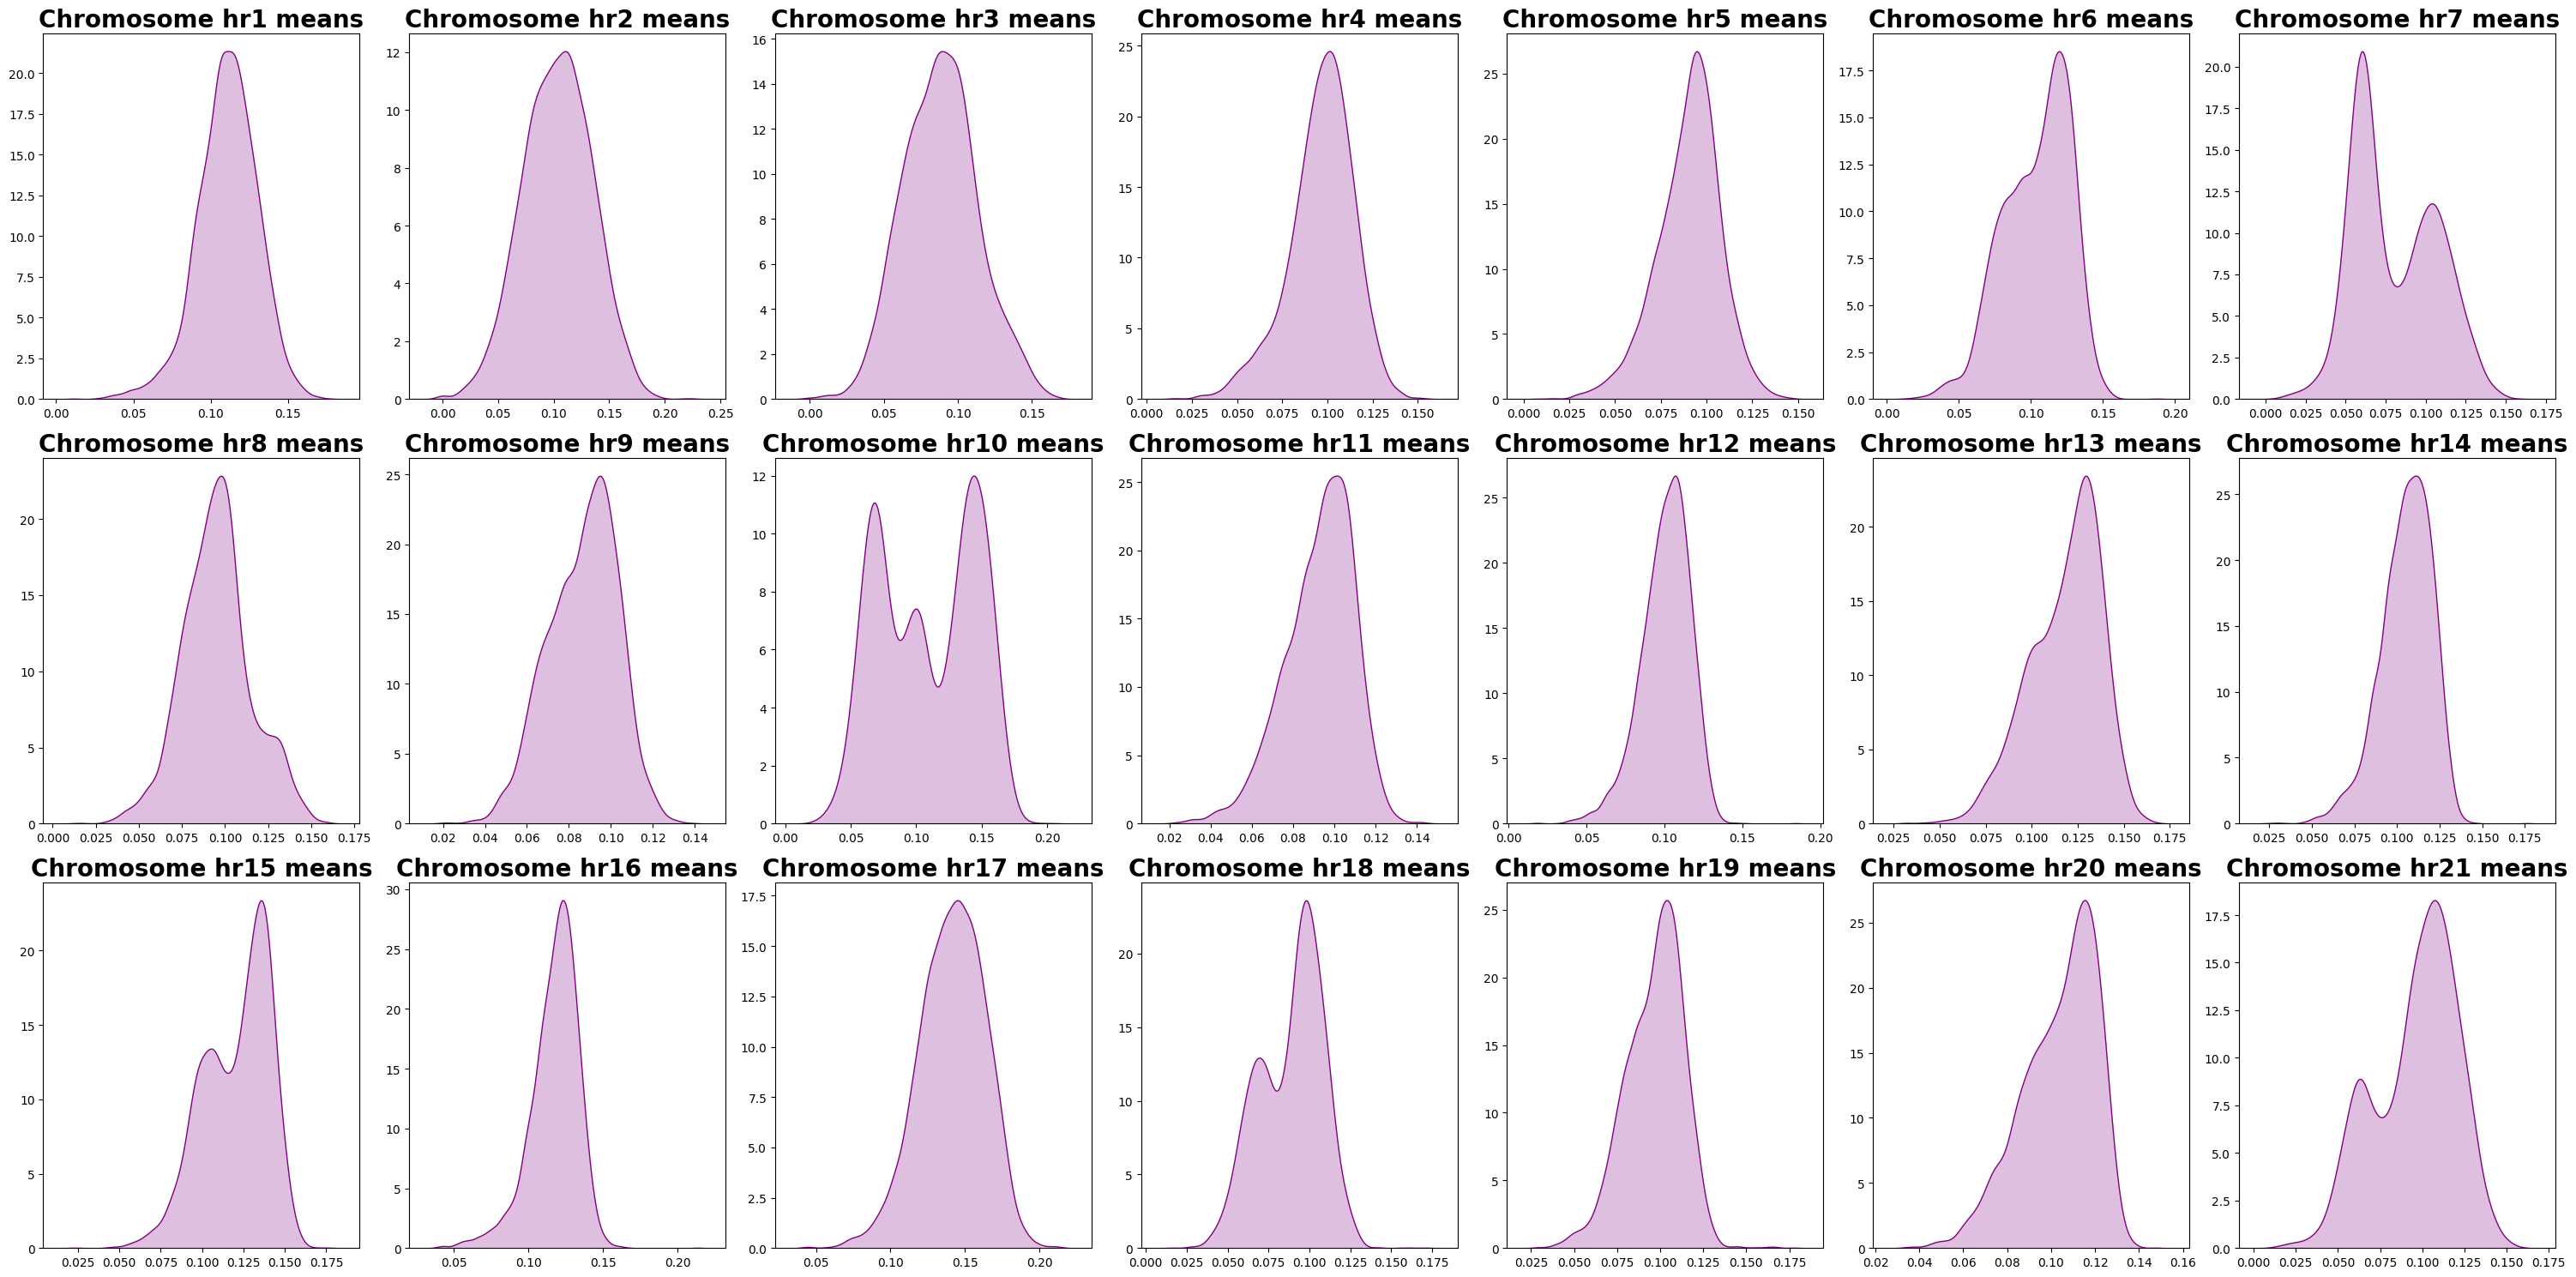

In [279]:
chr = [f'Chr{i+1}' for i in range(22)]
plot_all(chromosome_means_val_v2, chr)

In [43]:
chromosome_means_val_v2["proba"] = model.predict_proba(chromosome_means_val_v2)[:, 1]
chromosome_means_val_v2["pred"] = (chromosome_means_val_v2["proba"] >= 0.5).astype(int)

chromosome_means_val_v2

,Chr1,Chr2,Chr3,Chr4,Chr5,Chr6,Chr7,Chr8,Chr9,Chr10,...,Chr15,Chr16,Chr17,Chr18,Chr19,Chr20,Chr21,Chr22,proba,pred
AAACCCAAGGCGATAC-1,0.095475,0.041141,0.066462,0.063583,0.060194,0.058197,0.048266,0.070561,0.072515,0.038492,...,0.092323,0.089593,0.124216,0.073215,0.067595,0.073449,0.112465,0.071501,0.001157,0
AAACCCAAGGCTGTAG-1,0.077983,0.041951,0.059788,0.083368,0.095063,0.071088,0.087089,0.049431,0.064913,0.062227,...,0.116401,0.088526,0.104063,0.043300,0.074244,0.083938,0.062912,0.056153,0.003802,0
AAACCCACAAGTCCCG-1,0.116657,0.128385,0.097672,0.101985,0.106447,0.117406,0.061617,0.105658,0.102758,0.147867,...,0.147315,0.114684,0.116651,0.102017,0.118685,0.124242,0.134578,0.132856,0.999940,1
AAACCCACAGATGCGA-1,0.139384,0.103941,0.070478,0.089985,0.077526,0.098603,0.130817,0.085034,0.060663,0.064932,...,0.109161,0.111618,0.127319,0.061713,0.078761,0.098347,0.097530,0.097287,0.000027,0
AAACCCACAGGTGAGT-1,0.132423,0.149906,0.133923,0.124402,0.110823,0.135520,0.113090,0.133551,0.091330,0.109635,...,0.149820,0.127600,0.136299,0.111146,0.104030,0.115888,0.134004,0.114781,0.509340,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCGCTACAA-1,0.125373,0.170407,0.118392,0.108294,0.120650,0.132798,0.121295,0.138956,0.097874,0.099231,...,0.151730,0.140396,0.117800,0.113879,0.110294,0.111120,0.124946,0.112891,0.209126,0
TTTGTTGAGGGTACGT-1,0.108337,0.059731,0.073820,0.098275,0.053446,0.067690,0.070960,0.063838,0.086402,0.067957,...,0.105806,0.116685,0.142065,0.069587,0.071009,0.075355,0.085599,0.071873,0.000386,0
TTTGTTGCATCCGGTG-1,0.082999,0.073016,0.076510,0.100556,0.069972,0.079645,0.108826,0.095750,0.062180,0.071975,...,0.096349,0.115834,0.133680,0.055323,0.080671,0.093359,0.086046,0.063629,0.000484,0
TTTGTTGGTCTACACA-1,0.117370,0.104128,0.095623,0.098719,0.097435,0.094030,0.064704,0.101312,0.086016,0.143445,...,0.125651,0.111426,0.141802,0.101222,0.102055,0.109937,0.122898,0.111554,0.996585,1


In [44]:
chromosome_means_val_v2['pred'].value_counts()

pred
1    2646
0    2482
Name: count, dtype: int64

In [45]:
chromosome_means_val_v2['label'] = chromosome_means_val_v2.index
res = chromosome_means_val_v2[['label', 'proba', 'pred']]
res = res.reset_index(drop=True)
res 

,label,proba,pred
0,AAACCCAAGGCGATAC-1,0.001157,0
1,AAACCCAAGGCTGTAG-1,0.003802,0
2,AAACCCACAAGTCCCG-1,0.999940,1
3,AAACCCACAGATGCGA-1,0.000027,0
4,AAACCCACAGGTGAGT-1,0.509340,1
...,...,...,...
5123,TTTGGTTTCGCTACAA-1,0.209126,0
5124,TTTGTTGAGGGTACGT-1,0.000386,0
5125,TTTGTTGCATCCGGTG-1,0.000484,0
5126,TTTGTTGGTCTACACA-1,0.996585,1


In [46]:
label = ['Glioblastoma cells' if x == 0 else 'Stromal cells' for x in res['pred'].tolist()]

In [47]:
res['class'] = label
res

,label,proba,pred,class
0,AAACCCAAGGCGATAC-1,0.001157,0,Glioblastoma cells
1,AAACCCAAGGCTGTAG-1,0.003802,0,Glioblastoma cells
2,AAACCCACAAGTCCCG-1,0.999940,1,Stromal cells
3,AAACCCACAGATGCGA-1,0.000027,0,Glioblastoma cells
4,AAACCCACAGGTGAGT-1,0.509340,1,Stromal cells
...,...,...,...,...
5123,TTTGGTTTCGCTACAA-1,0.209126,0,Glioblastoma cells
5124,TTTGTTGAGGGTACGT-1,0.000386,0,Glioblastoma cells
5125,TTTGTTGCATCCGGTG-1,0.000484,0,Glioblastoma cells
5126,TTTGTTGGTCTACACA-1,0.996585,1,Stromal cells


In [48]:
res.to_csv('/home/amismailov/result_ML_val2.csv', index=False)

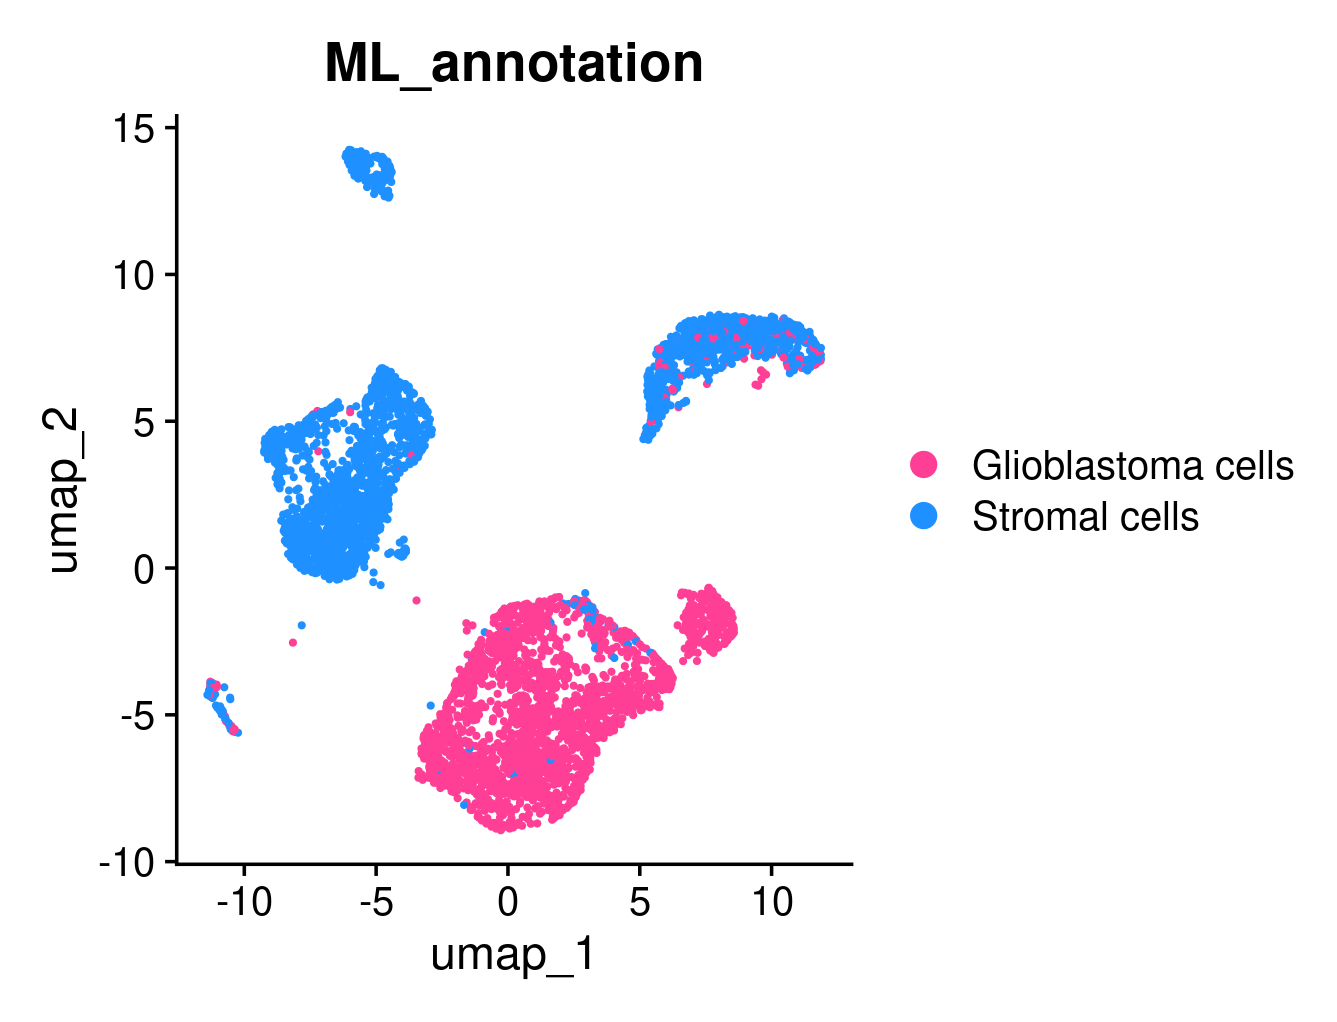
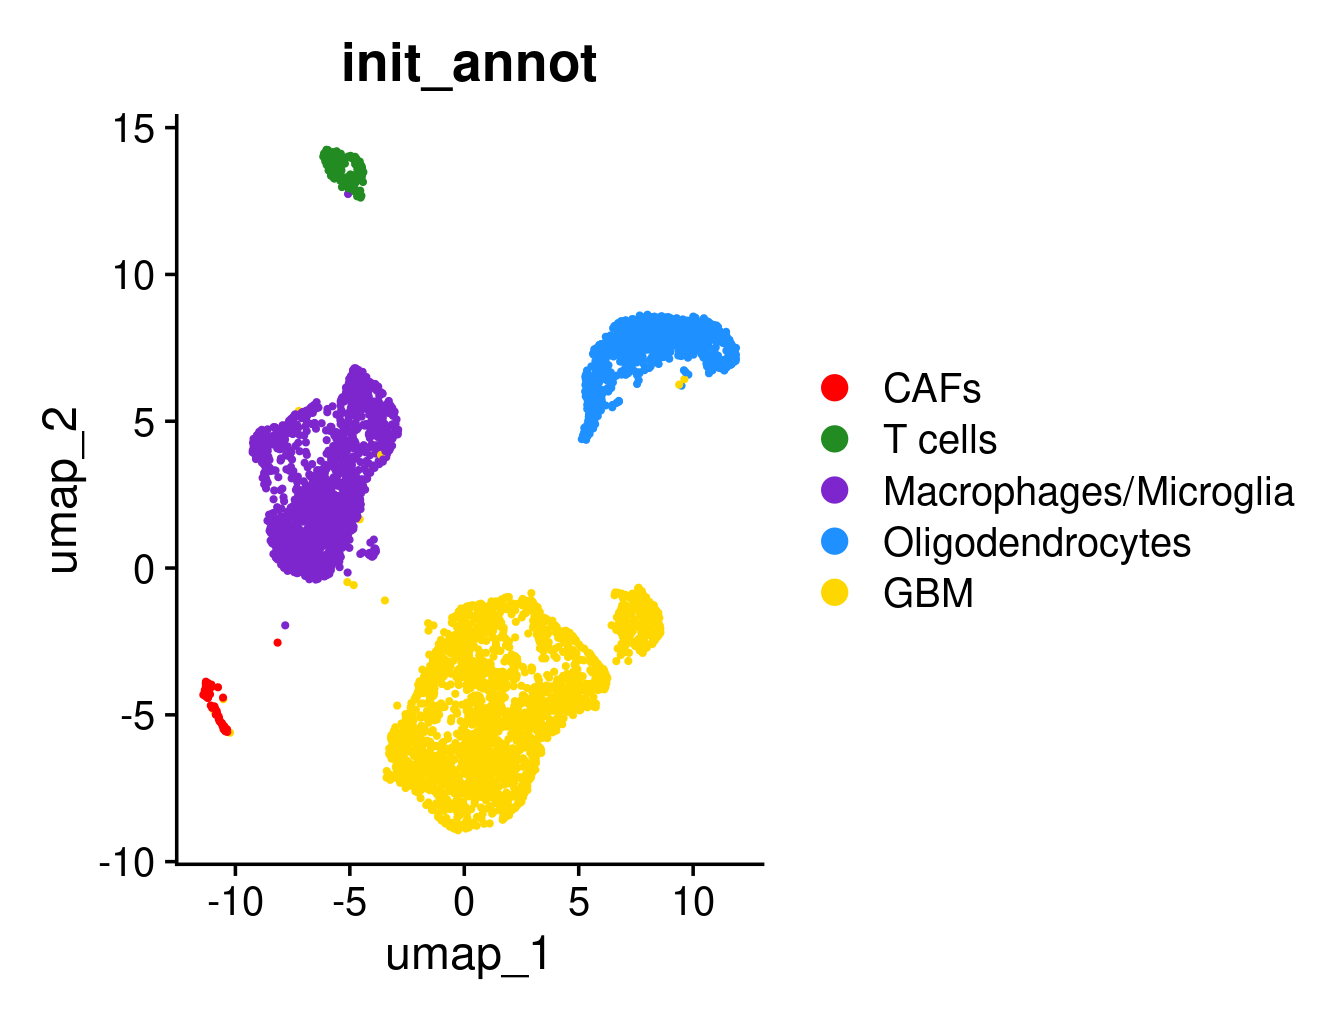

## VALIDATION DATASET №3

In [49]:
chromosome_means_val_v3 = pd.read_csv('/home/amismailov/chromosome_means_validation_v3.csv', index_col=0)
chromosome_means_val_v3

,Chr1,Chr2,Chr3,Chr4,Chr5,Chr6,Chr7,Chr8,Chr9,Chr10,...,Chr13,Chr14,Chr15,Chr16,Chr17,Chr18,Chr19,Chr20,Chr21,Chr22
AAACCTGCACAACTGT-1,0.047192,0.072834,0.056358,0.073589,0.048420,0.097435,0.038938,0.073537,0.076013,0.141055,...,0.082644,0.044952,0.053527,0.058682,0.081618,0.064812,0.074875,0.072407,0.059441,0.066856
AAACCTGCACCAGCAC-1,0.037118,0.089951,0.048017,0.080429,0.037377,0.111310,0.042958,0.081673,0.082095,0.153956,...,0.092405,0.042631,0.061246,0.041635,0.074244,0.057387,0.074084,0.078668,0.075878,0.061787
AAACCTGGTCAGGACA-1,0.049801,0.054984,0.060979,0.066783,0.037225,0.095058,0.042388,0.065144,0.067193,0.120930,...,0.082261,0.049849,0.062297,0.053315,0.088626,0.056866,0.067507,0.076836,0.074647,0.066967
AAACGGGAGCTGCCCA-1,0.056021,0.057264,0.069228,0.089738,0.049855,0.103528,0.057326,0.089807,0.087519,0.127398,...,0.101727,0.058625,0.058871,0.058539,0.085623,0.060371,0.078794,0.089572,0.084297,0.075722
AAACGGGTCTGTGCAA-1,0.054378,0.087745,0.068724,0.077601,0.053559,0.105809,0.051177,0.083707,0.074307,0.124331,...,0.095621,0.061872,0.065200,0.052680,0.082393,0.056132,0.075031,0.084504,0.066753,0.077921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTACTGGTCGCGTGT-99,0.073288,0.075091,0.062515,0.063328,0.068843,0.074657,0.029250,0.081107,0.065953,0.116428,...,0.102427,0.076380,0.089489,0.081889,0.094277,0.073402,0.064102,0.076258,0.047961,0.082587
TTTGCGCAGAAACCGC-99,0.088426,0.080909,0.076434,0.067431,0.072481,0.087229,0.040370,0.084892,0.072688,0.106109,...,0.091739,0.078836,0.088815,0.079368,0.076104,0.077082,0.080035,0.082830,0.046415,0.082630
TTTGCGCCACCACGTG-99,0.093659,0.086478,0.067903,0.071617,0.082345,0.093225,0.036975,0.071313,0.068876,0.103403,...,0.093921,0.074131,0.090598,0.077263,0.082524,0.075894,0.076819,0.081919,0.047133,0.081255
TTTGCGCGTACCGGCT-99,0.086856,0.082733,0.063219,0.073322,0.071727,0.089845,0.039759,0.068295,0.072790,0.101614,...,0.090072,0.069440,0.085780,0.083897,0.095192,0.081197,0.073469,0.080077,0.050725,0.084817


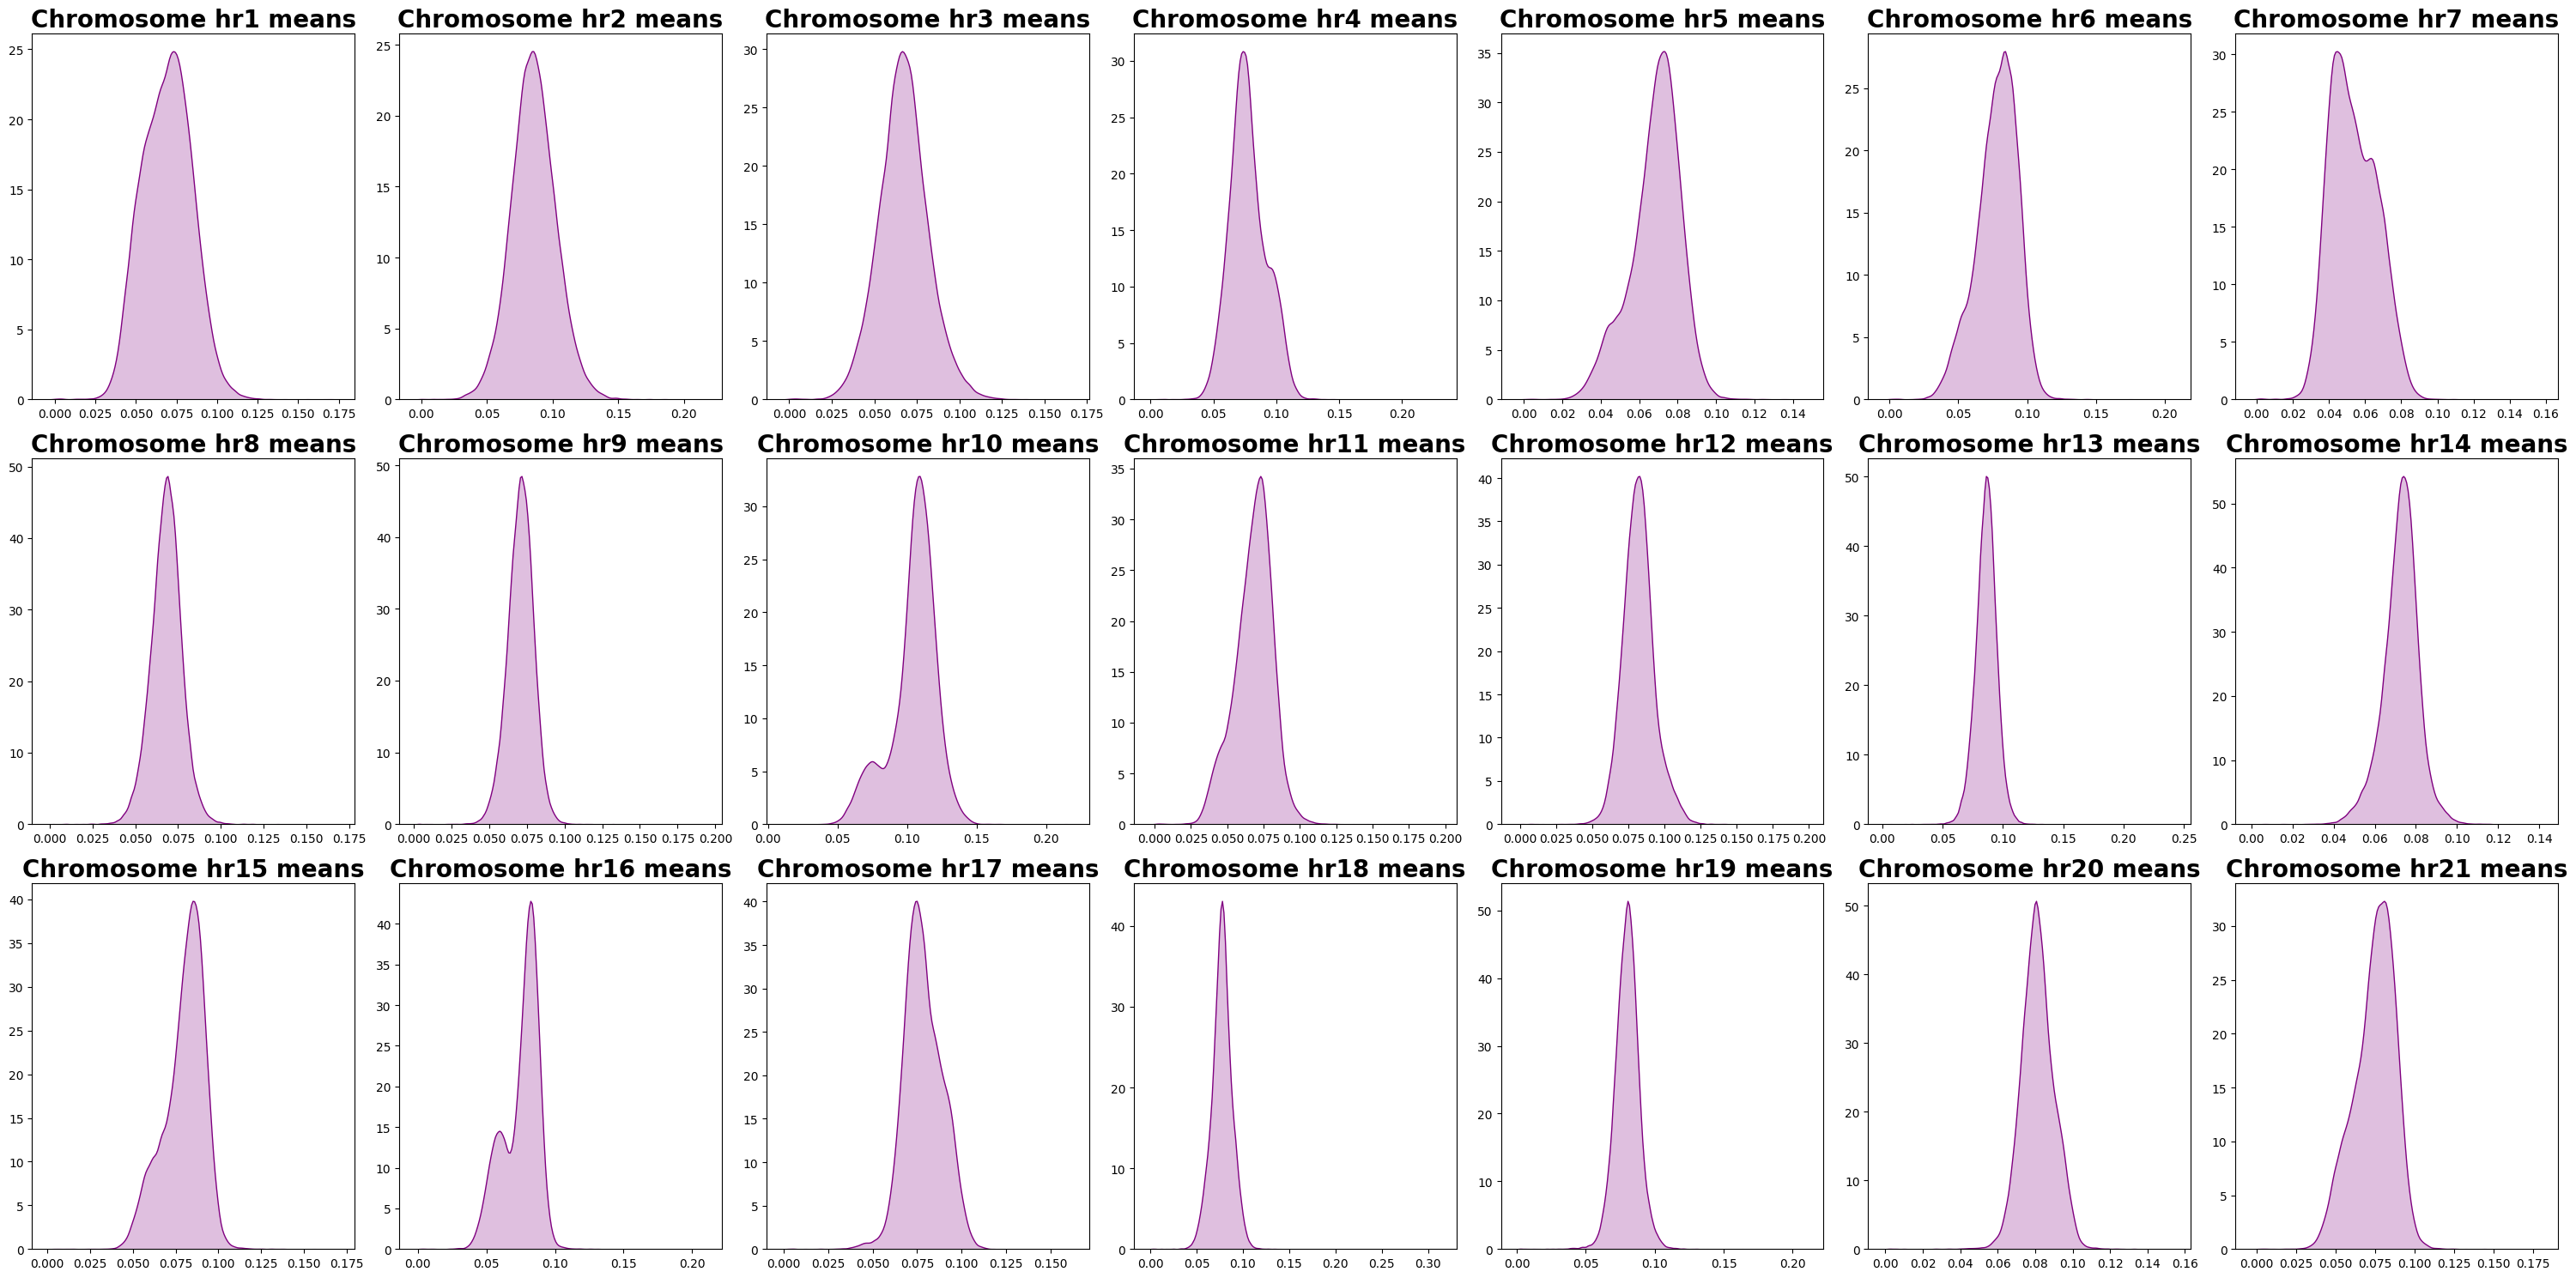

In [448]:
chr = [f'Chr{i+1}' for i in range(22)]
plot_all(chromosome_means_val_v3, chr)

In [50]:
chromosome_means_val_v3["proba"] = model.predict_proba(chromosome_means_val_v3)[:, 1]
chromosome_means_val_v3["pred"] = (chromosome_means_val_v3["proba"] >= 0.5).astype(int)

In [51]:
chromosome_means_val_v3['pred'].value_counts()

pred
1    57801
0     7355
Name: count, dtype: int64

In [52]:
chromosome_means_val_v3['label'] = chromosome_means_val_v3.index
res = chromosome_means_val_v3[['label', 'proba', 'pred']]
res = res.reset_index(drop=True)
res 

,label,proba,pred
0,AAACCTGCACAACTGT-1,1.000000,1
1,AAACCTGCACCAGCAC-1,1.000000,1
2,AAACCTGGTCAGGACA-1,0.999999,1
3,AAACGGGAGCTGCCCA-1,1.000000,1
4,AAACGGGTCTGTGCAA-1,0.999994,1
...,...,...,...
65151,TTTACTGGTCGCGTGT-99,0.999733,1
65152,TTTGCGCAGAAACCGC-99,0.994546,1
65153,TTTGCGCCACCACGTG-99,0.980976,1
65154,TTTGCGCGTACCGGCT-99,0.951081,1


In [53]:
label = ['Glioblastoma cells' if x == 1 else 'Stromal cells' for x in res['pred'].tolist()]

In [54]:
res['class'] = label
res

,label,proba,pred,class
0,AAACCTGCACAACTGT-1,1.000000,1,Glioblastoma cells
1,AAACCTGCACCAGCAC-1,1.000000,1,Glioblastoma cells
2,AAACCTGGTCAGGACA-1,0.999999,1,Glioblastoma cells
3,AAACGGGAGCTGCCCA-1,1.000000,1,Glioblastoma cells
4,AAACGGGTCTGTGCAA-1,0.999994,1,Glioblastoma cells
...,...,...,...,...
65151,TTTACTGGTCGCGTGT-99,0.999733,1,Glioblastoma cells
65152,TTTGCGCAGAAACCGC-99,0.994546,1,Glioblastoma cells
65153,TTTGCGCCACCACGTG-99,0.980976,1,Glioblastoma cells
65154,TTTGCGCGTACCGGCT-99,0.951081,1,Glioblastoma cells


In [55]:
res.to_csv('/home/amismailov/result_ML_val3.csv', index=False)

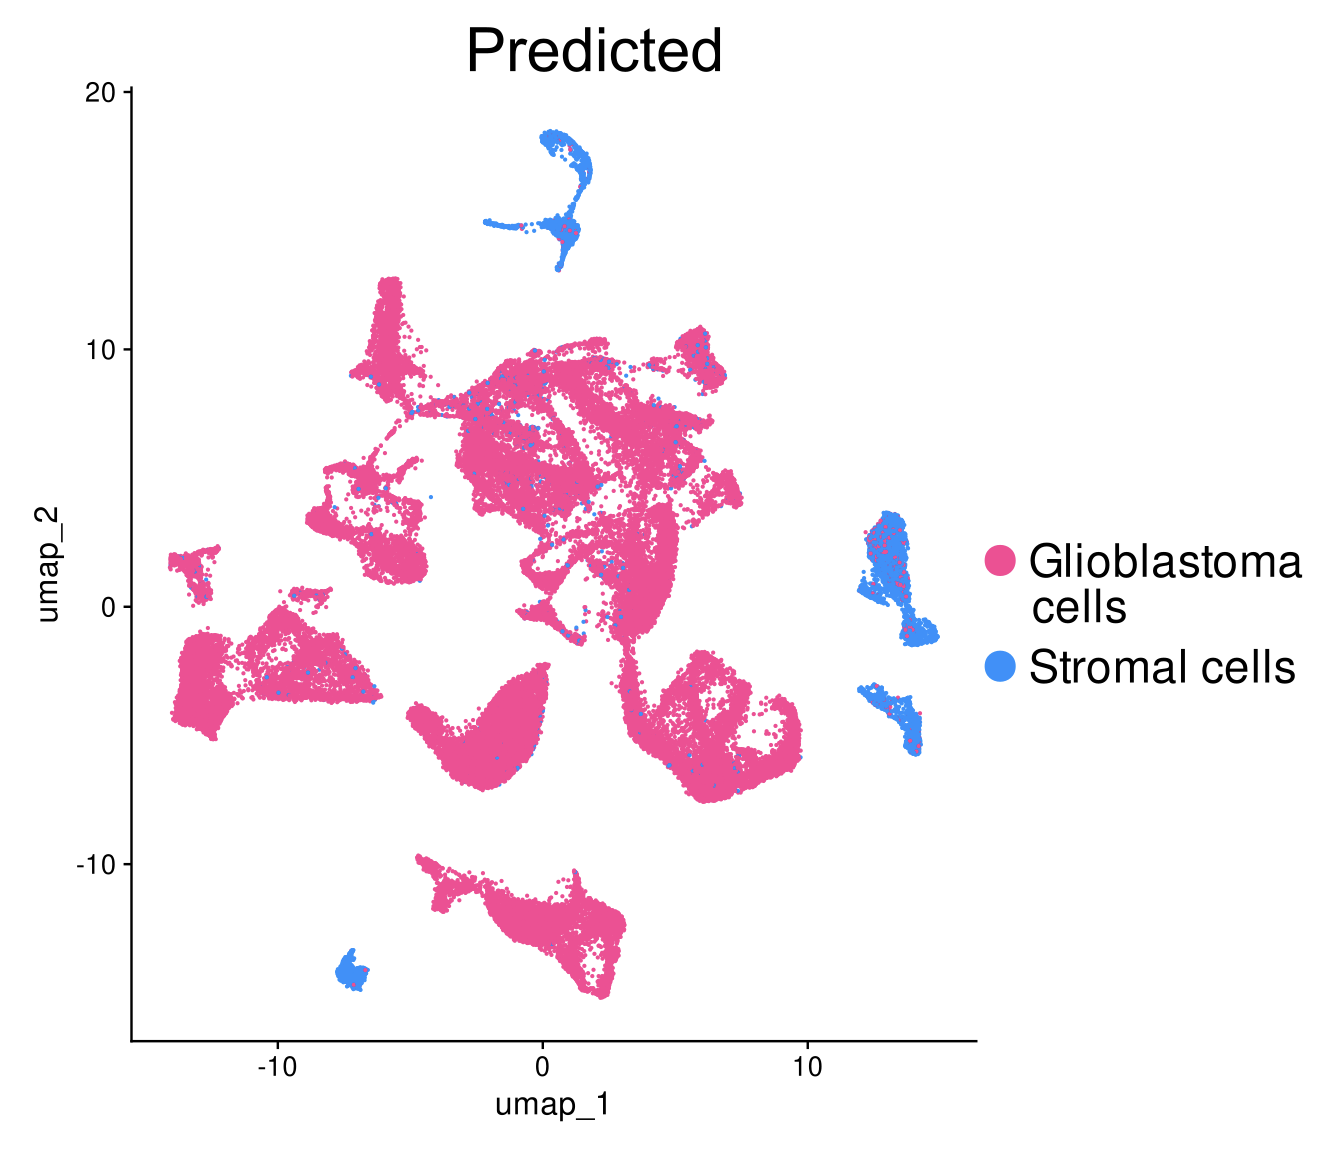
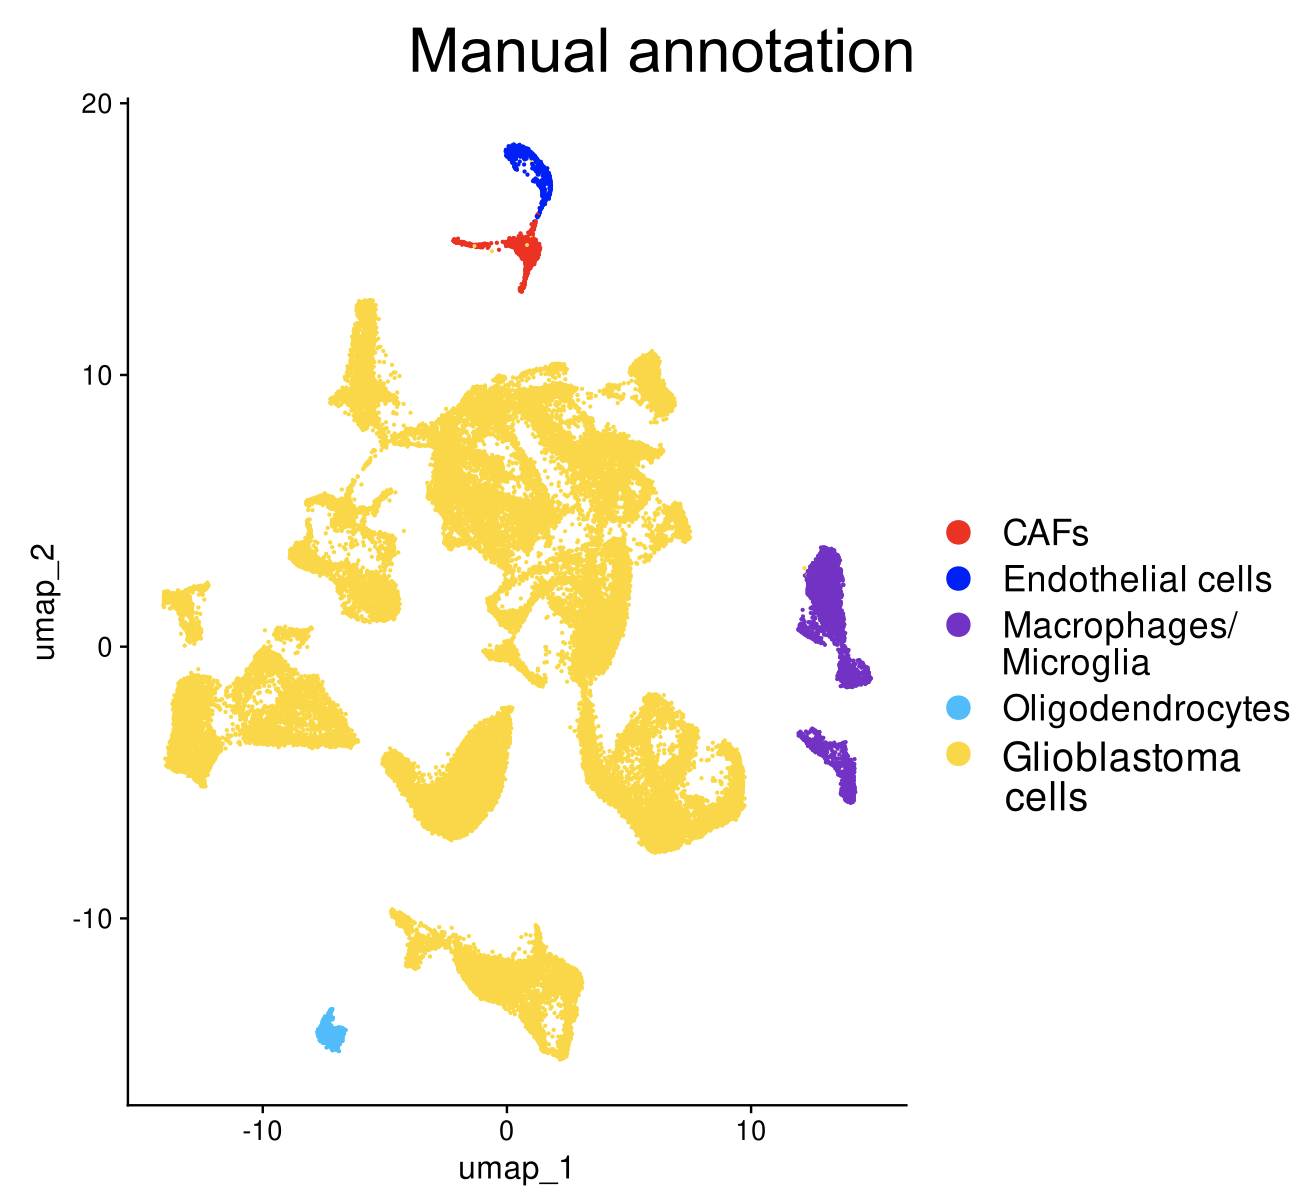